# Elección de la ubicación de los polos a lazo cerrado

## Sistema de segundo orden dominante

Una forma de seleccionar la ubicación de los polos es hacer lo mismo que se hacía en control clásico, es decir buscar que el sistema sea parecido a un segundo orden dominante. 

Esto es perfectamente factible en control moderno. Sin embargo, tiene la desventaja que no sabemos para nada que sucederá con el esfuerzo de control $u$. Ubicando los polos de esta manera podemos obtener esfuerzos de control imposibles de realizar por nuestros actuadores, o que lleven a consumos de energías demasiado altos para nuestro sistema.

Por esto, lo más recomendable es usar técnicas de control óptimo para seleccionar los polos del sistema a lazo cerrado.

## Lugar simétrico de las raíces

Una técnica de control óptimo ampliamente usado es el control `regulador cuadrático lineal (LQR)`. En este curso veremos una versión simplificada que se conoce como __Lugar de las Raíces Simétrico__. Esta versión simplificada consiste en resolver el problema de minimización del siguiente índice de costo:

$$\mathcal J = \int_0^{\infty}\left[\rho z^2(t)+u^2(t)\right]dt$$

donde:

$$
\mathbf{\dot x} = \mathbf{Ax}+\mathbf B u\\
z =  \mathbf{C_1x}\\
$$

mediante la ley de control:

$$ u =-\mathbf{Kx}$$


Se puede demostrar que la ubicación de los polos a lazo cerrado que minimizan el funcional de costo anterior, son los polos estables del lugar simétrico de las raíces dado por la ecuación:

$$1+\rho G_0(-s)G_0(s)=0$$
 
donde $G_0(s)$ es:

$$G_0(s) = \frac{Z(s)}{U(s)}=\mathbf{C_1}(s\mathbf I -\mathbf A)^{-1}\mathbf B$$

Por lo tanto el problema lo podemos resolver para todo $\rho$ haciendo un lugar simétrico de las raíces de $G_0(-s)G_0(s)$. El lugar dará simétrico respecto del eje $j\omega$ ya que los polos y ceros de $G_0(-s)G_0(s)$ también estarán ubicados de forma simétrica.


## Ejemplo de modos para la ley de control 

Dado el sistema con las siguientes ecuaciones de estado:

$$\dot{\mathbf{x}}(t) = \begin{bmatrix} -3 & 2 \\ -1 & 0 \end{bmatrix} \mathbf{x}(t) + \begin{bmatrix} 1 \\ 0 \end{bmatrix} u(t) $$

$$ y(t) = \begin{bmatrix} 1& -3 \end{bmatrix} \mathbf{x}(t) $$

Obtener leyes de control (una por cada item) que cumplan con las siguientes especificaciones:
- que el tiempo de asentamiento sea menos a 8 segundos y que el sobrevalor sea menor a 10%
- igual que el anterior pero diseñar utilizando el lugar simétrico de las raíces
- utilizando también el lugar simétrico de las raíces utilizar un $\rho$ 10 veces más grande que el anterior

In [1]:
import control as ctrl
import numpy as np
import matplotlib.pyplot as plt

Definimos primero las matrices del sistema:

In [2]:
A=[[-3, 2],[-1,0]]
B=[[1],[0]]
C=[[1,-3]]
D=0

y ahora definimos el sistema con el módulo de `control`.

In [3]:
sys = ctrl.ss(A,B,C,D)
sys
ctrl.tf(sys)

TransferFunction(array([1., 3.]), array([1., 3., 2.]))

### Ubicando los polos con el criterio de 2do orden dominante


Usando el criterio de hacer el sistema de segundo orden dominante, pondremos los polos en la posición que correspondería a ese segundo orden dominante. Para eso vemos la zona del plano $s$ que cumple con el 
tiempo de establecimiento solicitado (se asume al 2%)

In [4]:
ts = 0.8
sigma=4/ts # al 2%
sigma

5.0

Ahora se busca la zona que cumple con el sobrevalor:

In [5]:
# SV menor al 10%
zeta=0.6
np.exp(-np.pi*zeta/(np.sqrt(1-zeta**2)))

0.09478022484215486

Obtenemos los polos objetivos:

In [6]:
wn=sigma/zeta
wd=wn*np.sqrt(1-zeta**2)
pobj=-sigma+1j*wd
pobj

(-5+6.666666666666668j)

In [7]:
K1=ctrl.acker(sys.A, sys.B, [pobj, pobj.conjugate()])
K1

array([[  7.        , -67.44444444]])

In [8]:
sys_ley_control1 = ctrl.ss(sys.A-sys.B@K1, [[0],[0]], sys.C, 0)
sys_ley_control1.pole()

array([-5.+6.66666667j, -5.-6.66666667j])

o también lo podemos verificar como:

In [9]:
np.linalg.eigvals(sys_ley_control1.A)

array([-5.+6.66666667j, -5.-6.66666667j])

### Utilizando el criterio del lugar simétrico de las raíces


Como en el enunciado no se nos da ningún indicio de como tomar $z(t)$ para utilizar en el criterio, lo que utilizaremos es $z(t)=y(t)$, por lo que $\mathbf{C}_1=\mathbf{C}$, y por ende $G(s) = G_o(s)$. Entonces podemos obtenemos $G(s)$:

In [10]:
G=ctrl.tf(sys)
G

TransferFunction(array([1., 3.]), array([1., 3., 2.]))

Por inspección podemos obtener el $G(-s)$:

In [11]:
Gm = ctrl.tf([-1,3],[1,-3,2])
Gm

TransferFunction(array([-1,  3]), array([ 1, -3,  2]))

A continuación se presenta una función que obtiene $G(-s)$ de un sistema SISO del módulo de `control` de Python.

In [12]:
def conjugate_tf(G):
    num = ctrl.tf(G).num[0][0]
    den = ctrl.tf(G).den[0][0]
    nume = [num[i]*((-1)**(len(num)%2+1-i)) for i in range(0, len(num))]
    dene = [den[i]*((-1)**(len(den)%2+1-i)) for i in range(0, len(den))]
    return ctrl.tf(nume,dene)

Probamos esa función:

In [13]:
Gm=conjugate_tf(G)
Gm

TransferFunction(array([-1.,  3.]), array([ 1., -3.,  2.]))

Ahora podemos hacer el LSR de las raíces.

In [14]:
%matplotlib inline

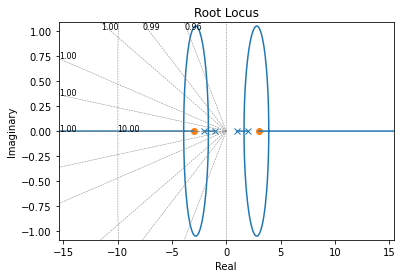

In [15]:
ctrl.rlocus(G*Gm);

Podemos ver en la figura, que se logran los objetivos seleccionados usando polos objetivos reales, uno lo podemos ibcar cerca de 5 y el otro queda cerca del cero, por lo que es esperable que no afecte demasiado el comportamiento.

In [16]:
r, k = ctrl.rlocus(G*Gm, kvect=[32], plot=False)
pobj= r[np.real(r)<0]
pobj

array([-5.05852977, -3.3780581 ])

In [17]:
K2 = ctrl.place(sys.A, sys.B, pobj)
K2

array([[  5.43658788, -15.08800749]])

Finalmente cerramos el lazo con esta ley de control

In [18]:
sys_ley_control2 = ctrl.ss(sys.A-sys.B@K2, [[0],[0]], sys.C, 0)
sys_ley_control2.pole()

array([-5.05852977, -3.3780581 ])

Podemos ver que el resutlado de esta ley de control tiene ganancias muy menores a la obtenida anteriormente.


### Ley de control usando un $\rho$ 10 veces más grande. 

Al hacer más grande a $\rho$ se está pesando más las desviaciones del sistema medidas en $z(t)$ que el esfuerzo de control $u(t)$, por lo que es de esperar que este sistema sea bastante más rápido que el obtenido anteriormente. También es de esperar que los movimientos en $u(t)$ sean mayores.

De lo dicho en la teoría, aumentar 10 veces el $\rho$ es aumenta 10 veces el $k$ para cual se obtienen los polos del lugar simétrico de las raíces. 

El $\rho$ obtenido en el punto anterior fue de 32. Entonces ahora usaremos un $\rho$ de 320.

In [19]:
r, k = ctrl.rlocus(G*Gm, kvect=[320], plot=False)
pobj= r[np.real(r)<0]
pobj

array([-17.77272212,  -3.02164665])

In [20]:
K3 = ctrl.place(sys.A, sys.B, pobj)
K3

array([[ 17.79436877, -51.70288633]])

Y definmos el sistema controlado:

In [21]:
sys_ley_control3 = ctrl.ss(sys.A-sys.B@K3, [[0],[0]], sys.C, 0)
sys_ley_control3.pole()

array([-17.77272212,  -3.02164665])

### Comparación usando de los 3 sistemas controlados

Voy a redifinir los 3 sistemas controlados, para tener a la salida también la variable $u(t)$. Sabemos que la varaible $u(t)$ es $-\mathbf{Kx}(t)$. Si quiero eso verlo en la salida, deberé redefinir la matriz $\mathbf{C}$ de forma que tenga una fila más que sea $-\mathbf{K}$. Por lo que la matriz $\mathbf{C}$ será:

In [22]:
C1 = np.vstack((sys_ley_control1.C,-K1))
sysf1=ctrl.ss(sys_ley_control1.A, 
                sys_ley_control1.B,
                C1, [[0],[0]])

C2 = np.vstack((sys_ley_control2.C,-K2))
sysf2=ctrl.ss(sys_ley_control2.A, 
                sys_ley_control2.B,
                C2, [[0],[0]])


C3 = np.vstack((sys_ley_control3.C,-K3))
sysf3=ctrl.ss(sys_ley_control3.A, 
                sys_ley_control3.B,
                C3, [[0],[0]])

Ahora entonces podemos simular a condicones iniciales no nulas:

In [23]:
t=np.linspace(0,2,501)
x0=[1,1]
t1,y1 = ctrl.initial_response(sysf1, T=t, X0=[1,1])
t2,y2 = ctrl.initial_response(sysf2, T=t, X0=[1,1])
t3,y3 = ctrl.initial_response(sysf3, T=t, X0=[1,1])

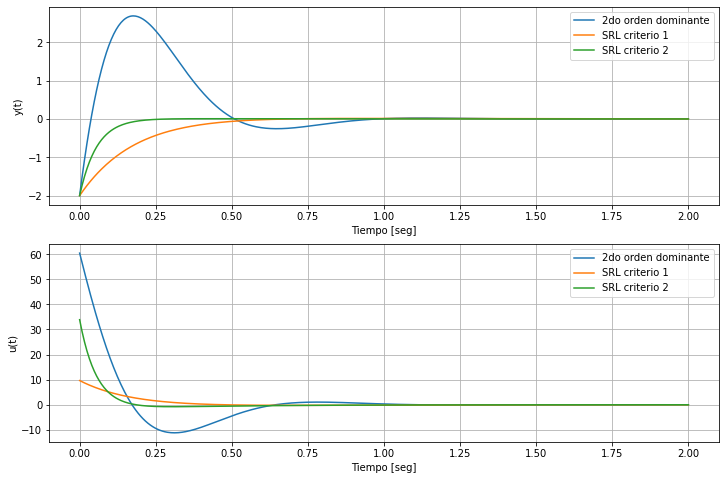

In [24]:
fig, ax = plt.subplots(2,1, figsize=(12,8))
ax[0].plot(t1, y1[0,:], label="2do orden dominante")
ax[0].plot(t2, y2[0,:], label="SRL criterio 1")
ax[0].plot(t3, y3[0,:], label="SRL criterio 2")
ax[0].grid()
ax[0].legend()
ax[0].set_xlabel('Tiempo [seg]')
ax[0].set_ylabel('y(t)')
ax[1].plot(t1, y1[1,:], label="2do orden dominante")
ax[1].plot(t2, y2[1,:], label="SRL criterio 1")
ax[1].plot(t3, y3[1,:], label="SRL criterio 2")
ax[1].grid()
ax[1].legend()
ax[1].set_xlabel('Tiempo [seg]')
ax[1].set_ylabel('u(t)');

Podemos ver, que el sistema al tener un cero nos arruinó lo que esperabamos del lazo segundo orden dominante.

Por otro lado, el sistema obtenido con el primer criterio de SRL  no tiene sobrevalor, cumple (o está muy cerca de cumplir) con todas las especificaciones y usa una $u(t)$ significativamente menor que los otros dos casos. 

Para el segundo caso del criterio SRL vemos que el sistema converge mucho más rápido que los casos anteriores. Aún así tiene menores movimientos de $u(t)$ que el caso 1. Esto es por que la posición de los polos objetivos fué elegida siguiendo criterios de optimización. En cambio el caso 1, la posición de los polos fué elegida para que cumpla una respuesta transitoria (o especificaciones) arbitrarias.